In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
!pip install missingno
import warnings

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
data=pd.read_csv("seattle-weather.csv")
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
# Display data shape
print(data.shape)

(1461, 6)


In [5]:
# Initial data analysis
print(data.describe())

       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000


In [6]:
# Data Preprocessing
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

In [7]:
# Check for missing values
print(data.isna().sum())

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64


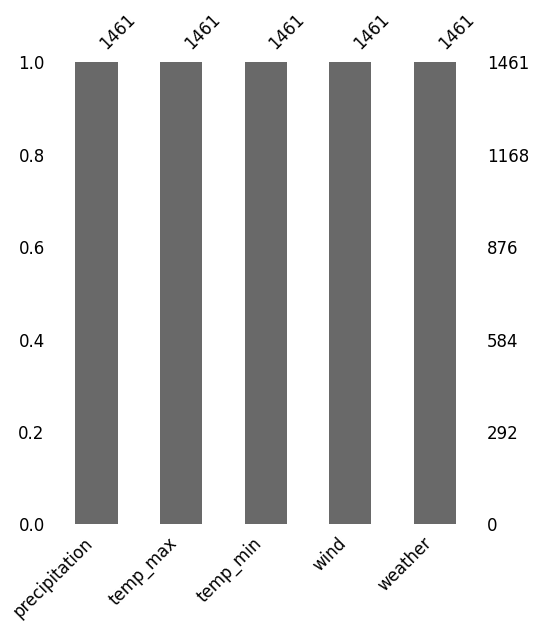

In [8]:
import missingno as msno

# Visualize missing values
plt.figure(figsize=(12, 6))
axz = plt.subplot(1, 2, 2)
msno.bar(data.drop(['date'], axis=1), ax=axz, fontsize=12)
plt.show()


In [9]:
# Inspect the dataset to confirm column names
print("Columns in the dataset:", data.columns)

Columns in the dataset: Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather'], dtype='object')


In [10]:
# Handling outliers using IQR
numerical_columns = data.select_dtypes(include=[np.number]).columns
Q1 = data[numerical_columns].quantile(0.25)
Q3 = data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[numerical_columns] < (Q1 - 1.5 * IQR)) | (data[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [11]:
# Transforming skewed data
if 'precipitation' in data.columns:
    data['precipitation'] = np.sqrt(data['precipitation'])
if 'wind' in data.columns:
    data['wind'] = np.sqrt(data['wind'])

In [12]:
# Encoding categorical data
if 'weather' in data.columns:
    lc = LabelEncoder()
    data['weather'] = lc.fit_transform(data['weather'])

In [13]:
# First, check the data types of your columns
print(data.dtypes)

# Drop non-numeric columns like 'date' (assuming 'date' is a column with datetime or object type)
data_cleaned = data.drop(columns=['date'])  # Replace 'date' with any non-numeric columns

# Ensure the 'weather' column is encoded if it is categorical (skip if already encoded)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_cleaned['weather'] = le.fit_transform(data_cleaned['weather'])

# Now proceed with PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
data_poly = poly.fit_transform(data_cleaned.drop('weather', axis=1))
data_poly = pd.DataFrame(data_poly, columns=poly.get_feature_names_out(data_cleaned.drop('weather', axis=1).columns))

print(data_poly.head())


date             datetime64[ns]
precipitation           float64
temp_max                float64
temp_min                float64
wind                    float64
weather                   int64
dtype: object
   precipitation  temp_max  temp_min      wind  precipitation^2  \
0       0.000000      12.8       5.0  2.167948              0.0   
1       0.894427      11.7       7.2  1.516575              0.8   
2       1.140175       8.9       2.8  2.469818              1.3   
3       1.581139       4.4       2.2  1.483240              2.5   
4       0.000000       7.2       2.8  1.516575              0.0   

   precipitation temp_max  precipitation temp_min  precipitation wind  \
0                0.000000                0.000000            0.000000   
1               10.464798                6.439876            1.356466   
2               10.147561                3.192491            2.816026   
3                6.957011                3.478505            2.345208   
4                0.000000 

In [14]:
# Scaling the features
scaler = StandardScaler()
data_poly = scaler.fit_transform(data_poly)

In [15]:
# Feature and target separation
X = data_poly
y = data['weather'].values

In [16]:
# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [17]:
# Defining models with hyperparameter tuning
knn = KNeighborsClassifier()
svm = SVC()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier()

In [18]:
# Hyperparameter tuning
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]}
param_grid_gbc = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
param_grid_xgb = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}

In [19]:
# GridSearchCV
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
grid_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5, scoring='accuracy')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')

In [20]:
# Training and evaluating models
models = {
    'KNN': grid_knn,
    'SVM': grid_svm,
    'GBC': grid_gbc,
    'XGB': grid_xgb
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'{name} accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%')
    print(f'Best parameters for {name}: {model.best_params_}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
    print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

KNN accuracy: 84.68%
Best parameters for KNN: {'n_neighbors': 9}
Confusion Matrix:
[[ 0  0  0  0  1]
 [ 0  2  0  0  9]
 [ 0  1 27  0  5]
 [ 0  0  2  1  0]
 [ 0  1  0  0 75]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.18      0.27        11
           2       0.93      0.82      0.87        33
           3       1.00      0.33      0.50         3
           4       0.83      0.99      0.90        76

    accuracy                           0.85       124
   macro avg       0.65      0.46      0.51       124
weighted avg       0.83      0.85      0.82       124

SVM accuracy: 83.87%
Best parameters for SVM: {'C': 10, 'gamma': 0.01}
Confusion Matrix:
[[ 0  0  0  0  1]
 [ 0  0  0  0 11]
 [ 0  0 27  0  6]
 [ 0  0  2  1  0]
 [ 0  0  0  0 76]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
  

In [21]:
# Model Optimization - Ensemble Method
ensemble = VotingClassifier(estimators=[
    ('knn', grid_knn.best_estimator_),
    ('svm', grid_svm.best_estimator_),
    ('gbc', grid_gbc.best_estimator_),
    ('xgb', grid_xgb.best_estimator_)
], voting='hard')

ensemble.fit(x_train, y_train)
y_pred_ensemble = ensemble.predict(x_test)
print(f'Ensemble accuracy: {accuracy_score(y_test, y_pred_ensemble) * 100:.2f}%')
print(f'Confusion Matrix (Ensemble):\n{confusion_matrix(y_test, y_pred_ensemble)}')
print(f'Classification Report (Ensemble):\n{classification_report(y_test, y_pred_ensemble)}')

Ensemble accuracy: 84.68%
Confusion Matrix (Ensemble):
[[ 0  0  0  0  1]
 [ 0  1  0  0 10]
 [ 0  0 27  0  6]
 [ 0  0  2  1  0]
 [ 0  0  0  0 76]]
Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.09      0.17        11
           2       0.93      0.82      0.87        33
           3       1.00      0.33      0.50         3
           4       0.82      1.00      0.90        76

    accuracy                           0.85       124
   macro avg       0.75      0.45      0.49       124
weighted avg       0.86      0.85      0.81       124



In [22]:
# Saving the best model (assuming Ensemble gave the best results)
best_model = ensemble
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [23]:
# Example prediction
input_data =  [[0.0, 30.0, 20.0, 2.0]]
input_data_poly = poly.transform(input_data)
input_data_scaled = scaler.transform(input_data_poly)
output = best_model.predict(input_data_scaled)
weather_condition = lc.inverse_transform(output)[0]
print(f'The predicted weather is: {weather_condition}')

The predicted weather is: sun


In [24]:
# Example prediction
input_data =  [[1.0, 22.0, 15.0, 5.0]]
input_data_poly = poly.transform(input_data)
input_data_scaled = scaler.transform(input_data_poly)
output = best_model.predict(input_data_scaled)
weather_condition = lc.inverse_transform(output)[0]
print(f'The predicted weather is: {weather_condition}')

The predicted weather is: rain


In [25]:
# Example prediction
input_data =  [[0.5, -2, 1, 2.0]]
input_data_poly = poly.transform(input_data)
input_data_scaled = scaler.transform(input_data_poly)
output = best_model.predict(input_data_scaled)
weather_condition = lc.inverse_transform(output)[0]
print(f'The predicted weather is: {weather_condition}')

The predicted weather is: drizzle


In [26]:
# Example prediction
input_data =  [[0.4, 3.0, -2.8, 5.3]]
input_data_poly = poly.transform(input_data)
input_data_scaled = scaler.transform(input_data_poly)
output = best_model.predict(input_data_scaled)
weather_condition = lc.inverse_transform(output)[0]
print(f'The predicted weather is: {weather_condition}')

The predicted weather is: snow


In [31]:
# Accept user input for the weather parameters
temperature = float(input("Enter temperature (in Celsius): "))
humidity = float(input("Enter humidity (in percentage): "))
pressure = float(input("Enter pressure (in hPa): "))
wind_speed = float(input("Enter wind speed (in m/s): "))

# Create an array for the input data
input_data = [[temperature, humidity, pressure, wind_speed]]

# Transform the input data using your pipeline
input_data_poly = poly.transform(input_data)
input_data_scaled = scaler.transform(input_data_poly)

# Make the prediction using the trained model
output = best_model.predict(input_data_scaled)

# Convert the encoded prediction back to the actual weather condition
weather_condition = lc.inverse_transform(output)[0]

# Print the result
print(f'The predicted weather is: {weather_condition}')


Enter temperature (in Celsius): 33
Enter humidity (in percentage): 71
Enter pressure (in hPa): 1011
Enter wind speed (in m/s): 3
The predicted weather is: rain
